In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
%matplotlib inline

In [2]:
# load data
df_customer = pd.read_csv('../data/Case Study - Customer.csv', sep=';')
df_product = pd.read_csv('../data/Case Study - Product.csv', sep=';')
df_store = pd.read_csv('../data/Case Study - Store.csv', sep=';')
df_transaction = pd.read_csv('../data/Case Study - Transaction.csv', sep=';')

In [3]:
# convert Date to datetime
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')
# fill missing values
df_customer.isna().sum()
df_customer.fillna(method='ffill', inplace=True)

In [4]:
# merge df
merged_df = pd.merge(df_transaction, df_product, on='ProductID', how='left')
merged_df = pd.merge(merged_df, df_store, on='StoreID', how='left')
merged_df = pd.merge(merged_df, df_customer, on='CustomerID', how='left')
merged_df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",36,0,Married,"10,53"
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,10000,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666",44,1,Married,"14,58"
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",27,1,Single,"0,18"
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",48,1,Married,"12,57"
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,10000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",33,0,Married,"6,95"


In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   Price_y         5020 non-null   int64         
 10  StoreName       5020 non-null   object        
 11  GroupStore      5020 non-null   object        
 12  Type            5020 non-null   object        
 13  Latitude        5020 non-null   object        
 14  Longitude       5020 non-null   object        
 15  Age 

In [6]:
# create df for regression
reg_df = df_transaction.groupby('Date')['Qty'].sum().reset_index()
reg_df['Date'] = pd.to_datetime(reg_df['Date'], format='%d/%m/%Y')
reg_df.sort_values(by='Date', inplace=True)
reg_df.set_index('Date', inplace=True)


<Axes: title={'center': 'Daily Sales'}, xlabel='Date', ylabel='Total Qty'>

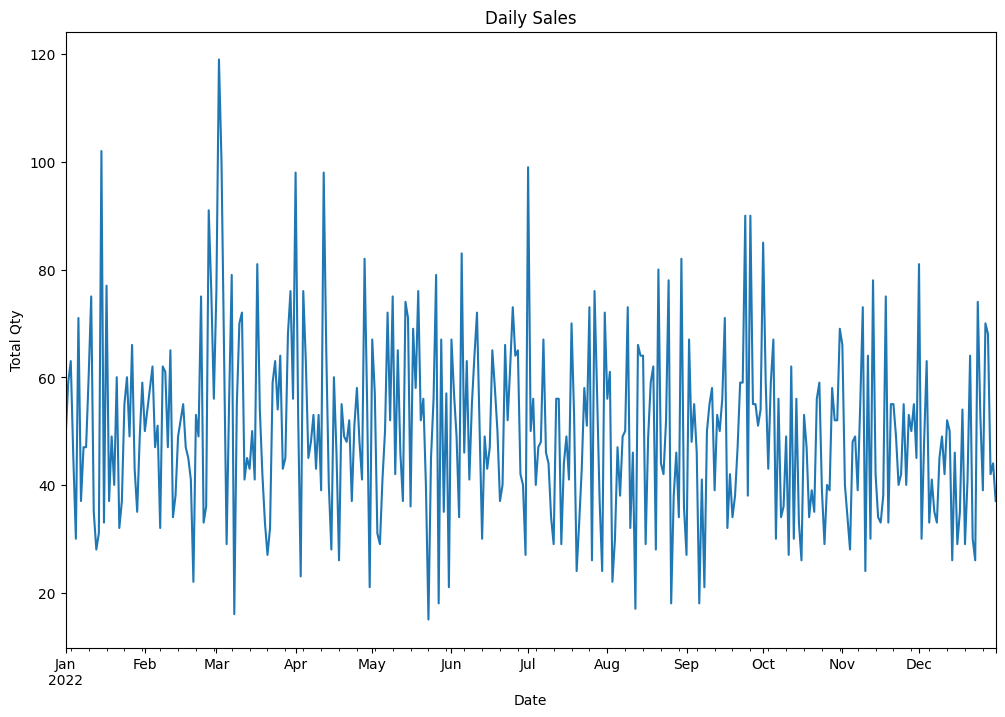

In [7]:
# plot qty sales in a year
reg_df.plot(figsize=(12,8), title='Daily Sales', xlabel='Date', ylabel='Total Qty', legend=False)

In [8]:
# split into training and testing data by 80/20
train = reg_df[:int(0.8*(len(reg_df)))]
test = reg_df[int(0.8*(len(reg_df))):]

In [9]:
# grid search for p, d, and q
auto_arima_model = pm.auto_arima(
    train['Qty'], 
    seasonal=False, 
    stepwise=False, 
    suppress_warnings=True, 
    trace = True
)
auto_arima_model.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=1.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2971.825, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2858.751, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2818.103, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2758.656, Time=0.23 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2742.865, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2688.721, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2504.937, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2506.794, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2508.733, Time=0.25 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2510.161, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2616.108, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2506.798, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(3,0,0)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1249.469
Date:                Sat, 02 Sep 2023   AIC                           2504.937
Time:                        12:56:40   BIC                           2515.968
Sample:                    01-01-2022   HQIC                          2509.356
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.08e-05   3.25e+04      0.000       1.000       1.000
ma.L1         -0.9898      0.015    -66.556      0.000      -1.019      -0.961
sigma2       298.6887     22.254     13.422      0.000     255.072     342.306
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                18.30
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.53
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# import sarimax
p, d, q = auto_arima_model.order
model = SARIMAX(train['Qty'].values, order=(p,d,q))
model_fit = model.fit(disp=False)

In [11]:
# count rsme
from sklearn.metrics import mean_squared_error
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
rmse = mean_squared_error(test, predictions, squared=False)
rmse

14.153760587024204

In [12]:
# forecasting for next 90 days
period = 90
forecast = model_fit.forecast(steps=period)
index = pd.date_range(start='01-01-2023', periods=period)
df_forecast = pd.DataFrame(forecast, index=index, columns=['Qty'])

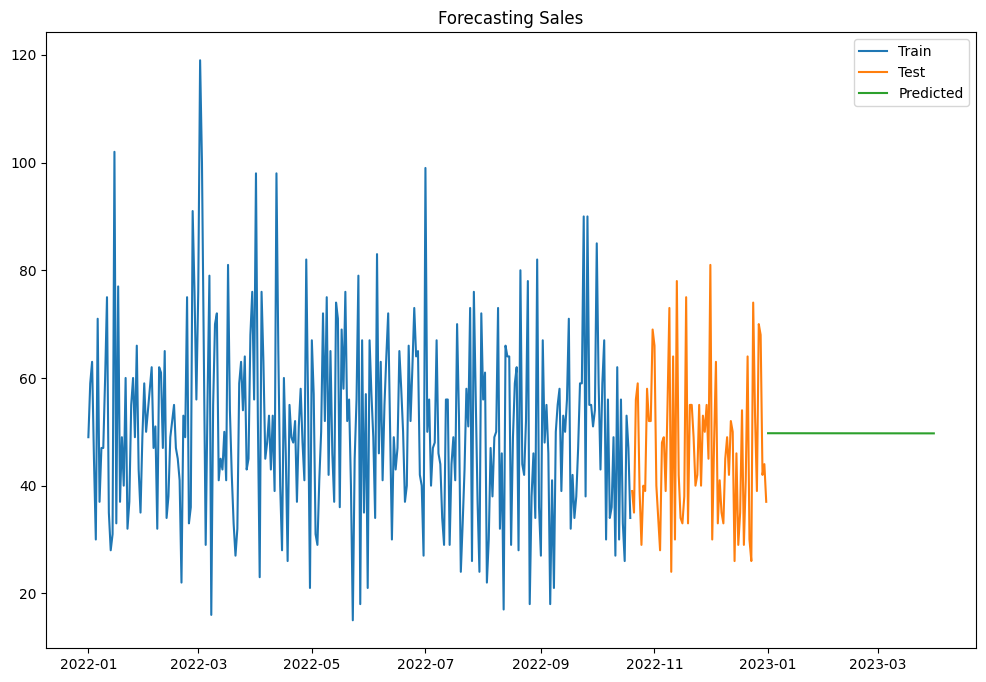

In [13]:
plt.figure(figsize=(12,8))
plt.title('Forecasting Sales')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(df_forecast, label='Predicted')
plt.legend(loc='best')
plt.show()

<Axes: title={'center': 'Forecasting Sales'}, xlabel='Date', ylabel='Total Qty'>

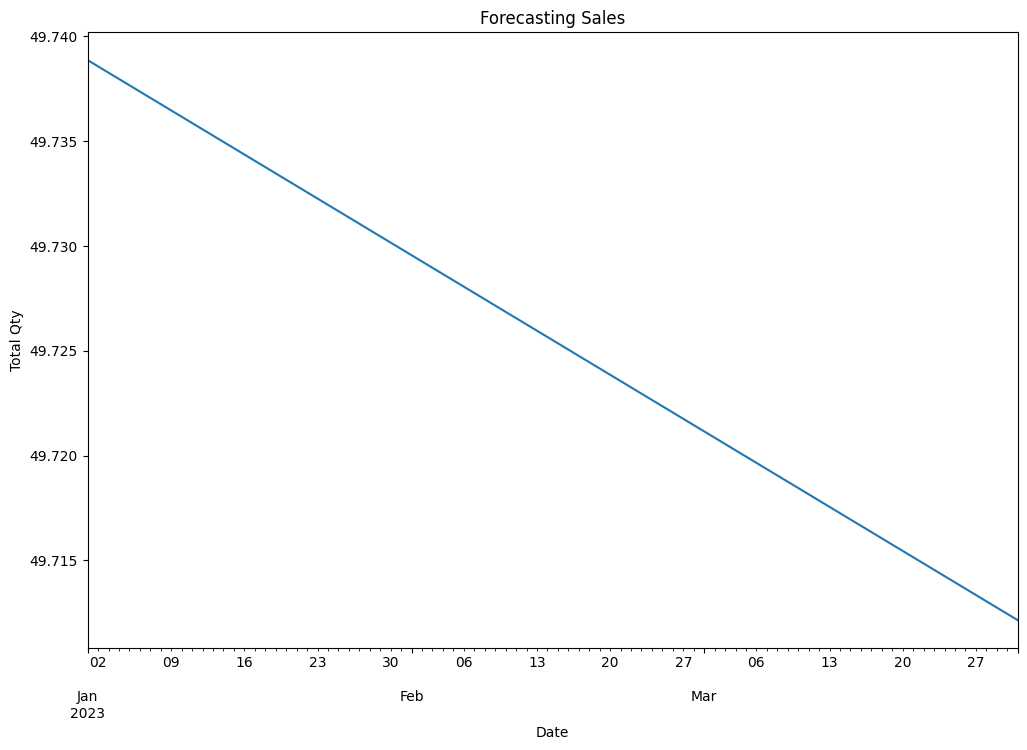

In [14]:
# plot forecast
df_forecast.plot(figsize=(12,8), title='Forecasting Sales', xlabel='Date', ylabel='Total Qty', legend=False)

In [15]:
# forecast product for next 90 days
warnings.filterwarnings('ignore')

product_reg_df = merged_df[['Qty', 'Date', 'Product Name']]
new = product_reg_df.groupby("Product Name")

forecast_product_df = pd.DataFrame({'Date': pd.date_range(start='2023-01-01', periods=90)})

for product_name, group_data in new:
    target_var = group_data['Qty']
    model = SARIMAX(target_var.values, order=(p,d,q))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(90)
    forecast_product_df[product_name] = forecast

forecast_product_df.set_index('Date', inplace=True)
forecast_product_df.head()

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
Date,,,,,,,,,,
2023-01-01,2.372071,2.968054,6.063639,4.014823,3.512834,4.952848,1.988827,2.798689,3.430740,4.01997
2023-01-02,2.372038,2.968054,6.063638,4.014823,3.512834,4.952848,1.988827,2.798689,3.430736,4.01997
2023-01-03,2.372006,2.968054,6.063638,4.014822,3.512834,4.952848,1.988827,2.798689,3.430732,4.01997
2023-01-04,2.371973,2.968054,6.063638,4.014822,3.512834,4.952848,1.988827,2.798689,3.430728,4.01997
2023-01-05,2.371940,2.968054,6.063638,4.014822,3.512834,4.952848,1.988827,2.798688,3.430725,4.01997


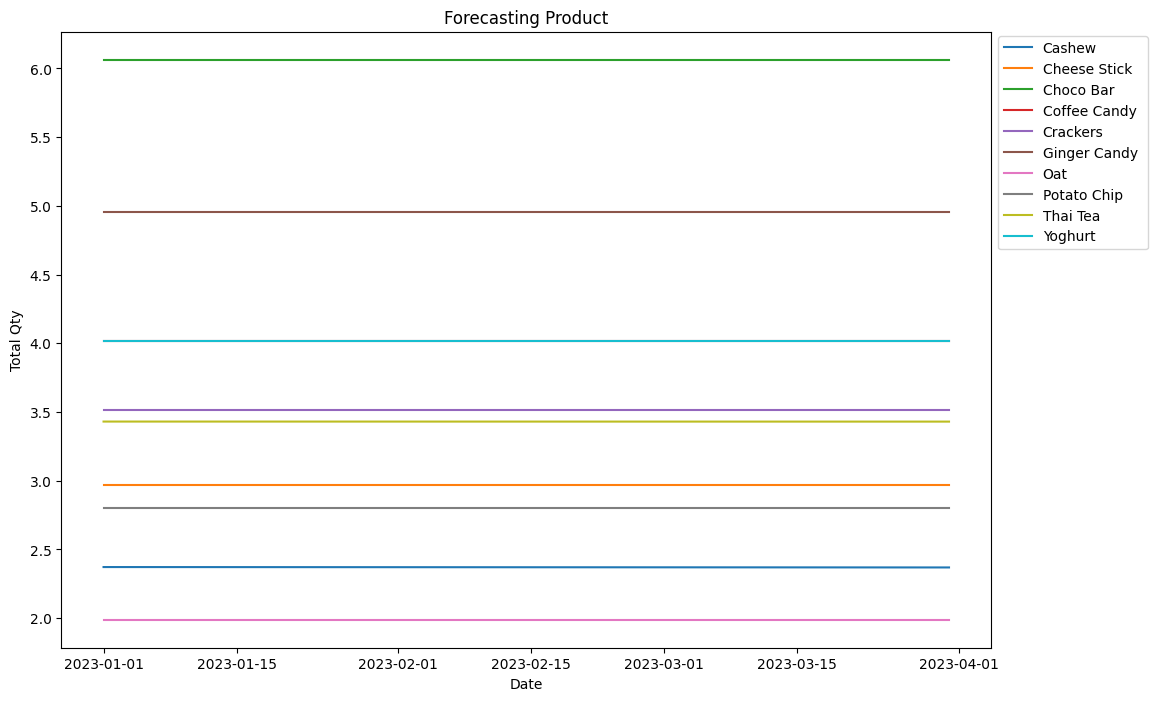

In [16]:
# plot forecast for products
plt.figure(figsize=(12,8))
for i in forecast_product_df.columns:
    plt.plot(forecast_product_df[i], label=i)
plt.legend(loc=6, bbox_to_anchor=(1,.82))
plt.title('Forecasting Product')
plt.xlabel('Date')
plt.ylabel('Total Qty')
plt.show()